## Lotka-Volterra

The purpose of this problem is to test the performance on easy problems. Since it's periodic, the error is naturally low, and so most of the difference will come down to startup times and, when measuring the interpolations, the algorithm choices.

In [1]:
using DifferentialEquations, ParameterizedFunctions

f = @ode_def LotkaVolterra begin
  dx = a*x - b*x*y
  dy = -c*y + d*x*y
end a=1.5 b=1 c=3 d=1

prob = ODEProblem(f,[1.0;1.0])

tspan = [0,10]
abstols = 1./10.^(6:13)
reltols = 1./10.^(3:10);
sol = solve(prob,tspan,alg=:Vern7,abstol=1/10^14,reltol=1/10^14)
test_sol = TestSolution(sol)

DifferentialEquations.TestSolution(nothing,DifferentialEquations.ODESolution, 745 timesteps, final value [1.02634,0.909691],true)


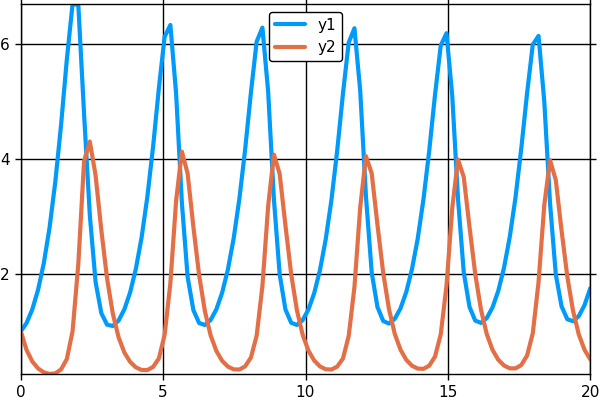

In [10]:
sol = solve(prob,tspan)
plot(sol)

### Low Order


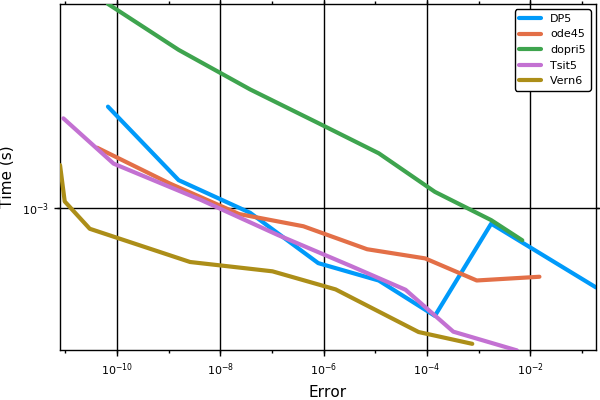

In [22]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:dopri5)
          Dict(:alg=>:Tsit5)
          Dict(:alg=>:Vern6)
]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;appxsol=test_sol,dense=false,save_timeseries=false,numruns=100,maxiters=10000)
plot(wp)

Here we see the times are nearly identical. They are so close that it's not able to resolve the scale on the time axis to differentiate between them. This is because it's an easy problem. The overhead of calling Fortran likely amounts to why `dopri5` does not do as well as the native algorithms here.

### Interpolation Error

Since the problem is periodic, the real measure of error is the error throughout the solution.


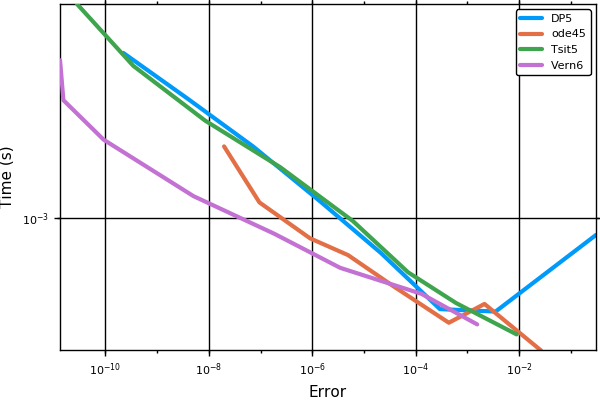

In [21]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:Tsit5)
          Dict(:alg=>:Vern6)
]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;appxsol=test_sol,dense=true,save_timeseries=true,numruns=100,maxiters=10000,error_estimate=:L2)
plot(wp)


Here we see the power of algorithm specific interpolations. The ODE.jl algorithm is only able to reach $10^{-7}$ error even at a tolerance of $10^{-13}$, while the DifferentialEquations.jl algorithms are below $10^{-10}$

## Higher Order


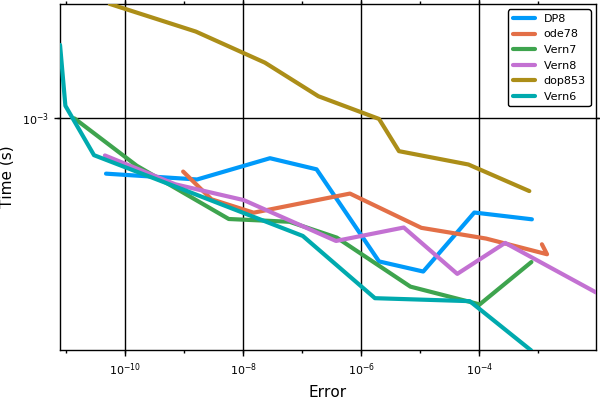

In [25]:
setups = [Dict(:alg=>:DP8)
          Dict(:alg=>:ode78)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern6)
]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;appxsol=test_sol,dense=false,save_timeseries=false,numruns=100,maxiters=1000)
plot(wp)

Again we look at interpolations:


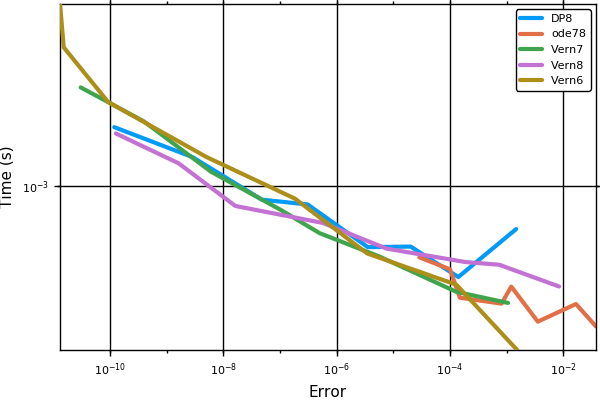

In [28]:
setups = [Dict(:alg=>:DP8)
          Dict(:alg=>:ode78)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:Vern6)
]
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;appxsol=test_sol,dense=true,save_timeseries=true,numruns=100,maxiters=1000,error_estimate=:L2)
plot(wp)

Again, the ODE.jl algorithms suffer when measuring the interpolations due to relying on an order 3 Hermite polynomial instead of an algorithm-specific order matching interpolation which uses the timesteps.

## Conclusion

The DifferentialEquations.jl and ODE.jl algorithms are pretty matched on this problem. All of the problems are too close on timing to actually resolve the y axis. However, you can clearly see the DifferentialEquations algorithms solving to a much higher accuracy, especially when the interpolations are involved.